<h1 align="center"> Introduction to Statistics with Python </h1>




Comparing Models using AIC and BIC
===

In [1]:
%reset -f
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import math as m
import scipy as sp
from statsmodels.stats.anova import anova_lm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Will fix figure size for this notebook
plt.rcParams["figure.figsize"] = (8,6)

Retrieving Data
===


In [3]:
# Retriving data which has been downloaded from yahoo and saved as CSV.

df1 = pd.read_csv('GSRet.csv', index_col = 0)
df2 = pd.read_csv('LogVol.csv', index_col = 0)

In [4]:
# GS daily log return
GSrtn = df1['x']
# Log of GS volume traded
GSLogVol = df2['x']
# GS volume traded
GSVol = np.exp(GSLogVol)

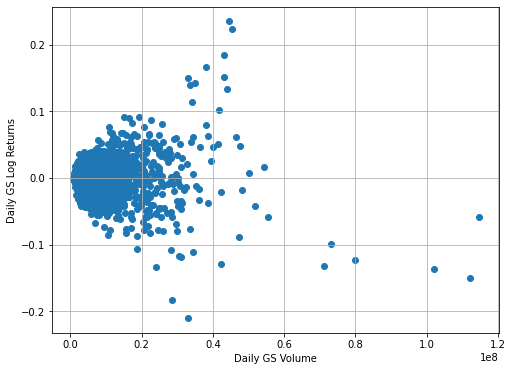

In [5]:
# Plot data 
plt.scatter(x=GSVol,y=GSrtn)
plt.xlabel('Daily GS Volume')
plt.ylabel('Daily GS Log Returns')
plt.grid()
plt.savefig("GS_WeightedLinearReg")

In [6]:
# Importing stats models and sklearn modules

from statsmodels.stats.anova import anova_lm
from sklearn import linear_model
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.formula.api as smf

Apply a set of regressions and compare models
====


In [7]:
#Let's look Volume being a predictor input for the Returns in a linear regression

X1 = GSVol.values
X1 = sm.add_constant(X1) # Need to add a constant to account for intercept
y = GSrtn

# Initialise model, fit and print results, including conf. interval

model = sm.OLS(y, X1)
lm_0 = model.fit()
res = lm_0.resid
resSqr = res**2
print(lm_0.summary())

                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     11.91
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           0.000565
Time:                        10:31:58   Log-Likelihood:                 7510.7
No. Observations:                3216   AIC:                        -1.502e+04
Df Residuals:                    3214   BIC:                        -1.501e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      2.315      0.0

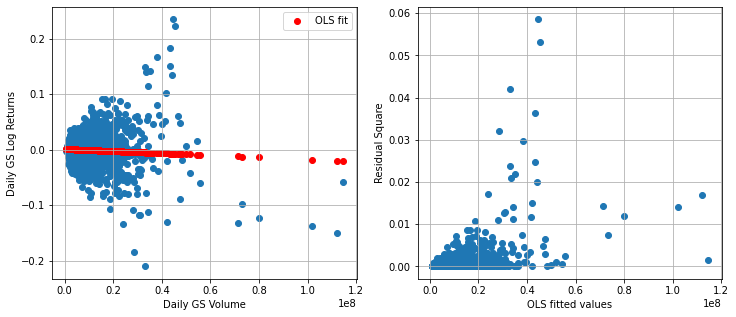

In [8]:
# Plot results
plt.figure(figsize=(12,5))
plt.subplot(1,2, 1)

x = GSVol
y = GSrtn
y_fitted_model0 = lm_0.fittedvalues
plt.scatter(x=x,y=y)
plt.grid()
plt.xlabel('Daily GS Volume')
plt.ylabel('Daily GS Log Returns')
plt.scatter(x,y_fitted_model0, color = 'red', label = 'OLS fit')
plt.legend()
plt.subplot(1,2, 2)
yfit = lm_0.fittedvalues
plt.scatter(x=x,y=resSqr)
plt.xlabel('OLS fitted values')
plt.ylabel('Residual Square')
plt.grid()
plt.savefig("Shape of ResSquare")

Objective is to find a model for res^2
====

- Given the Linear Regression above, can we try to model the squared of residuals as a proxy for variance and hence adjust the regression with appropriate weights?

- We can try a series of models and use our knowledge on model selection to pick the best one. 

In [9]:
# Fit a linear regression on square of residuals against Volume

X1 = GSVol.values
X1 = sm.add_constant(X1) # Need to add a constant to account for intercept
y = resSqr.values
model = sm.OLS(y, X1)
lm_var1 = model.fit()
print(lm_var1.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     997.8
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          5.85e-191
Time:                        10:32:02   Log-Likelihood:                 15327.
No. Observations:                3216   AIC:                        -3.065e+04
Df Residuals:                    3214   BIC:                        -3.064e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005   4.88e-05     -9.853      0.0

In [10]:
# Finding the bSpline / natural cubic spline in Python
import patsy
from patsy import dmatrix

In [11]:
# Data
x = GSVol
y = resSqr

# Use Natural Spline Regression
data = {"x": x}
x_ns_5 = dmatrix("cr(x, df=5)-1", data)
x_ns_5 = np.asarray(x_ns_5)
x_ns_5 = sm.add_constant(x_ns_5)

model = sm.OLS(y, x_ns_5)
lm_var2 = model.fit()
print(lm_var2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     267.5
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          1.23e-198
Time:                        10:32:04   Log-Likelihood:                 15354.
No. Observations:                3216   AIC:                        -3.070e+04
Df Residuals:                    3211   BIC:                        -3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.000     14.234      0.0

In [12]:
# For every linear regression, data on influence can be obtained
# This includes cooks_distance

infl = lm_var2.get_influence()
sm_fr = infl.summary_frame()
sm_fr.head()

,dfb_const,dfb_x1,dfb_x2,dfb_x3,dfb_x4,dfb_x5,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
1,0.000007,1.361790e-06,-0.000008,-1.990915e-06,0.000002,0.000003,1.302453e-10,0.000862,0.001051,0.000028,0.000862,0.000028
2,-0.000073,3.194877e-07,0.000081,2.101550e-05,-0.000012,-0.000035,1.308133e-08,-0.008871,0.000996,-0.000280,-0.008869,-0.000280
3,0.000509,3.558654e-04,-0.000705,-2.281827e-05,0.000478,0.000056,1.621666e-06,0.102681,0.000922,0.003119,0.102665,0.003119
4,-0.000646,-2.688392e-04,0.000833,1.452845e-04,-0.000325,-0.000200,1.596827e-06,-0.097143,0.001014,-0.003095,-0.097128,-0.003095
5,0.000037,2.957510e-05,-0.000053,9.150898e-07,0.000041,0.000001,1.010885e-08,0.008209,0.000899,0.000246,0.008208,0.000246


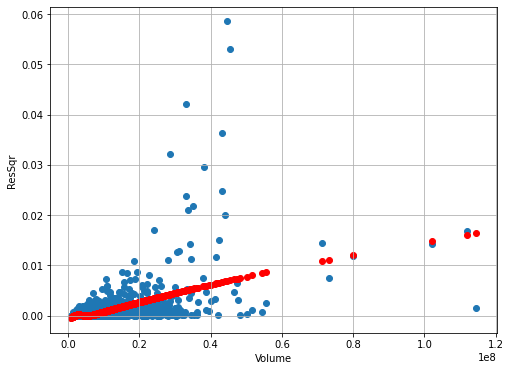

In [13]:
x = GSVol
y = resSqr

model_fitted_y = lm_var2.fittedvalues
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('ResSqr')
plt.xlabel('Volume')
plt.scatter(x,model_fitted_y, color = 'red')
plt.show()

In [14]:
# Data
x = np.log(GSVol.values)
y = resSqr

# Use Natural Spline Regression on log GS Volume
data = {"x": x}
logx_ns_5 = dmatrix("cr(x, df=5)-1", data)
logx_ns_5 = np.asarray(logx_ns_5)
logx_ns_5 = sm.add_constant(logx_ns_5)

model = sm.OLS(y, logx_ns_5)
lm_var3 = model.fit()
print(lm_var3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     291.4
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          5.03e-214
Time:                        10:32:12   Log-Likelihood:                 15390.
No. Observations:                3216   AIC:                        -3.077e+04
Df Residuals:                    3211   BIC:                        -3.074e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.000     20.466      0.0

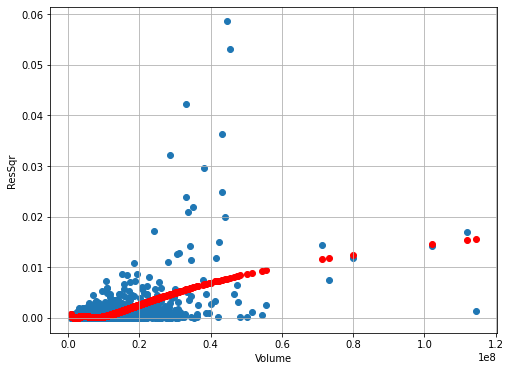

In [15]:
x = GSVol
y = resSqr

model_fitted_y = lm_var3.fittedvalues
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('ResSqr')
plt.xlabel('Volume')
plt.scatter(x,model_fitted_y, color = 'red')
plt.show()

In [16]:
# Data
x = np.log(GSVol).values
y = resSqr

# Use Natural Spline Regression on x and ln x combined
data = {"x": x}
logx_ns_5 = dmatrix("cr(x, df=5)-1", data)
logx_ns_5 = np.asarray(x_ns_5)
X_logx_ns_5_log = np.concatenate((x_ns_5,logx_ns_5), axis=1)
X_logx_ns_5_log.shape

model = sm.OLS(y, X_logx_ns_5_log)
lm_var4 = model.fit()
print(lm_var4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     267.5
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          1.23e-198
Time:                        10:32:14   Log-Likelihood:                 15354.
No. Observations:                3216   AIC:                        -3.070e+04
Df Residuals:                    3211   BIC:                        -3.067e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014   9.69e-05     14.234      0.0

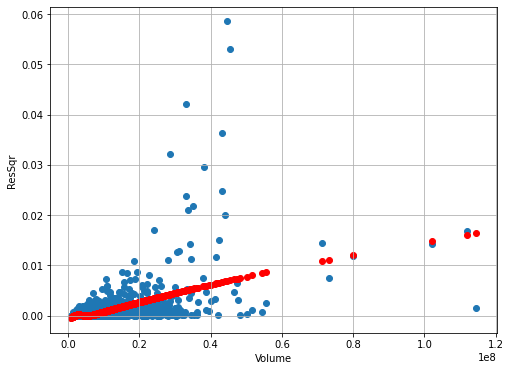

In [17]:
x = GSVol
y = resSqr
model_fitted_y = lm_var4.fittedvalues
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('ResSqr')
plt.xlabel('Volume')
plt.scatter(x,model_fitted_y, color = 'red')
plt.show()


In [18]:
# Data
x = GSVol
y = resSqr

# Use Natural Spline Regression
data = {"x": x}
x_ns_10 = dmatrix("cr(x, df=10)-1", data)
x_ns_10 = np.asarray(x_ns_10)
x_ns_10 = sm.add_constant(x_ns_10)

model = sm.OLS(y, x_ns_10)
lm_var5 = model.fit()
print(lm_var5.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     131.3
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          5.09e-211
Time:                        10:32:16   Log-Likelihood:                 15396.
No. Observations:                3216   AIC:                        -3.077e+04
Df Residuals:                    3206   BIC:                        -3.071e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000     11.916      0.0

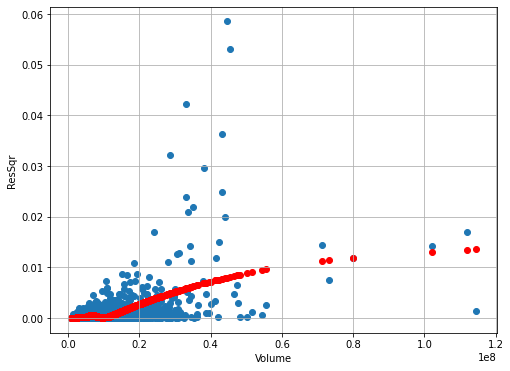

In [19]:
x = GSVol
y = resSqr

model_fitted_y = lm_var5.fittedvalues
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('ResSqr')
plt.xlabel('Volume')
plt.scatter(x,model_fitted_y, color = 'red')
plt.show()



In [20]:
# Data
x = np.log(GSVol).values
y = resSqr

# Use Natural Spline Regression
data = {"x": x}
logx_ns_10 = dmatrix("cr(x, df=10)-1", data)
logx_ns_10 = np.asarray(logx_ns_10)
logx_ns_10 = sm.add_constant(logx_ns_10)

model = sm.OLS(y, logx_ns_10)
lm_var6 = model.fit()
print(lm_var6.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     135.0
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          3.17e-216
Time:                        10:32:18   Log-Likelihood:                 15408.
No. Observations:                3216   AIC:                        -3.080e+04
Df Residuals:                    3206   BIC:                        -3.074e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000     16.677      0.0

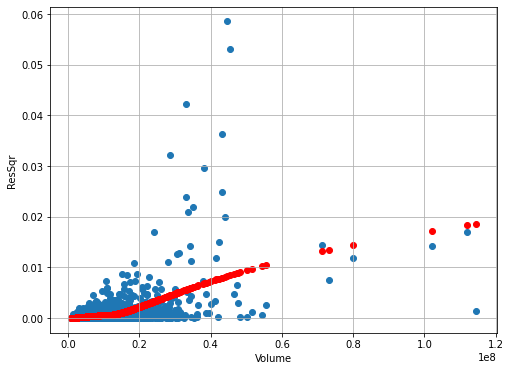

In [21]:
x = GSVol
y = resSqr

model_fitted_y = lm_var6.fittedvalues
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('ResSqr')
plt.xlabel('Volume')
plt.scatter(x,model_fitted_y, color = 'red')
plt.show()

In [22]:
# Data
x = np.log(GSVol).values
y = resSqr
# Use Natural Spline Regression
data = {"x": x}
logx_ns_10 = dmatrix("cr(x, df=10)-1", data)
logx_ns_10 = np.asarray(logx_ns_10)
ns_10_logx_ns_10 = np.concatenate((x_ns_10,logx_ns_10), axis=1)

model = sm.OLS(y, ns_10_logx_ns_10)
lm_var7 = model.fit()
print(lm_var7.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     77.76
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          6.53e-236
Time:                        10:32:20   Log-Likelihood:                 15476.
No. Observations:                3216   AIC:                        -3.091e+04
Df Residuals:                    3197   BIC:                        -3.080e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      4.876      0.0

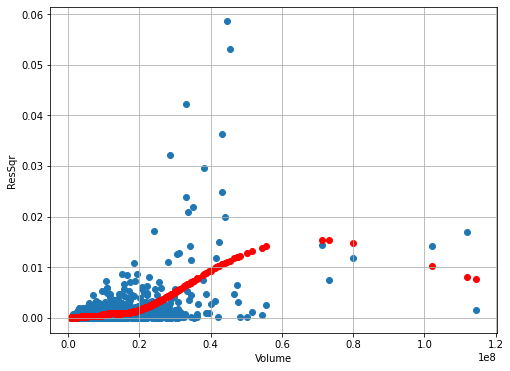

In [23]:
x = GSVol
y = resSqr

model_fitted_y = lm_var7.fittedvalues
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('ResSqr')
plt.xlabel('Volume')
plt.scatter(x,model_fitted_y, color = 'red')
plt.show()


In [24]:
from statsmodels.stats.anova import anova_lm

table1 = anova_lm(lm_var1,lm_var2)
table2 = anova_lm(lm_var1,lm_var3)
table3 = anova_lm(lm_var1,lm_var4)
table4 = anova_lm(lm_var2,lm_var4)
table5 = anova_lm(lm_var3,lm_var4)
table6 = anova_lm(lm_var4,lm_var5)
table7 = anova_lm(lm_var2,lm_var5)

print(table1)
print(table2)
print(table3)
print(table4)
print(table5)
print(table6)
print(table7)


   df_resid       ssr  df_diff   ss_diff          F        Pr(>F)
0    3214.0  0.013658      0.0       NaN        NaN           NaN
1    3211.0  0.013425      3.0  0.000233  18.576435  6.043470e-12
   df_resid       ssr  df_diff   ss_diff          F        Pr(>F)
0    3214.0  0.013658      0.0       NaN        NaN           NaN
1    3211.0  0.013131      3.0  0.000527  42.918983  3.455585e-27
   df_resid       ssr  df_diff   ss_diff          F        Pr(>F)
0    3214.0  0.013658      0.0       NaN        NaN           NaN
1    3211.0  0.013425      3.0  0.000233  18.576435  6.043470e-12
   df_resid       ssr  df_diff  ss_diff   F  Pr(>F)
0    3211.0  0.013425      0.0      NaN NaN     NaN
1    3211.0  0.013425     -0.0     -0.0 NaN     NaN
   df_resid       ssr  df_diff   ss_diff    F  Pr(>F)
0    3211.0  0.013131      0.0       NaN  NaN     NaN
1    3211.0  0.013425     -0.0 -0.000294  inf     NaN
   df_resid       ssr  df_diff   ss_diff          F        Pr(>F)
0    3211.0  0.013425 

In [25]:
# Model selection with AIC/BIC

aic_values = [lm_var1.aic, lm_var2.aic,lm_var3.aic,lm_var4.aic,lm_var5.aic,lm_var6.aic,lm_var7.aic]
bic_values = [lm_var1.bic, lm_var2.bic,lm_var3.bic,lm_var4.bic,lm_var5.bic,lm_var6.bic,lm_var7.bic]

models = ['var1','var2','var3','var4','var5','var6','var7']
model_selection = pd.DataFrame(np.array([models,aic_values,bic_values]).T, columns = ['model','aic','bic'])
model_selection

,model,aic,bic
0,var1,-30649.126277176532,-30636.974489915934
1,var2,-30698.463527801672,-30668.084059650177
2,var3,-30769.56530883898,-30739.185840687485
3,var4,-30698.463527801672,-30668.084059650177
4,var5,-30772.782538582585,-30712.023602279598
5,var6,-30796.97547410545,-30736.216537802462
6,var7,-30913.451110933296,-30798.009131957617


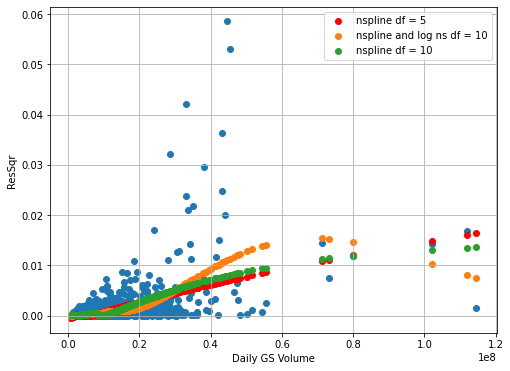

In [26]:
x = GSVol
y = resSqr

y_5 = lm_var5.fittedvalues
y_4 = lm_var4.fittedvalues
y_7 = lm_var7.fittedvalues

plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('ResSqr')
plt.xlabel('Daily GS Volume')
plt.scatter(x,y_4, color = "red",label = "nspline df = 5")
plt.scatter(x,y_7,label = "nspline and log ns df = 10")
plt.scatter(x,y_5, label = "nspline df = 10")
plt.legend()
plt.savefig("GS_various_param_res2")



Weighted Regression
====

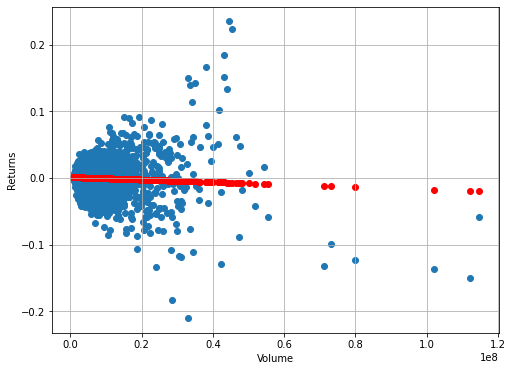

In [27]:
# Unweighted regression
X1 = GSVol.values
X1 = sm.add_constant(X1) # Need to add a constant to account for intercept
y = GSrtn
model = sm.OLS(y, X1)
lm_0 = model.fit()

# Plot results
model_fitted_y = lm_0.fittedvalues
x = GSVol
y = GSrtn
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('Returns')
plt.xlabel('Volume')
plt.scatter(x,model_fitted_y, color = 'red')
plt.show()

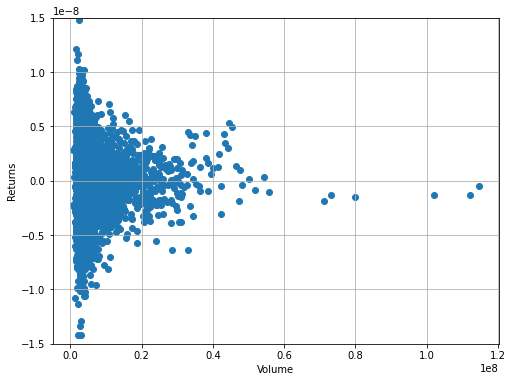

In [28]:
#Rescaling returns by Volume - homoskedastic?

x = GSVol
temp = (1+GSVol.values)
y = GSrtn.values
y_temp = y/temp

plt.scatter(x=x,y=y_temp)
plt.grid()
plt.ylabel('Returns')
plt.xlabel('Volume')
plt.ylim(( -1.5e-8,1.5e-8))
plt.show()

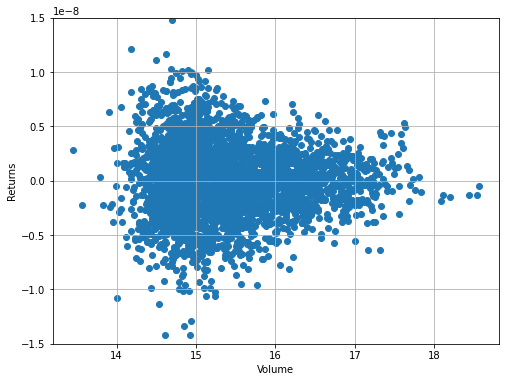

In [29]:
#Easier scale to observe

x_log = np.log(GSVol)
temp = (1+GSVol.values)
y = GSrtn.values
y_temp = y/temp
plt.scatter(x=x_log,y=y_temp)
plt.grid()
plt.ylabel('Returns')
plt.xlabel('Volume')
plt.ylim((-1.5e-8,1.5e-8))
plt.show()

                            WLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8175
Date:                Fri, 30 Oct 2020   Prob (F-statistic):              0.366
Time:                        10:32:30   Log-Likelihood:                 8620.0
No. Observations:                3216   AIC:                        -1.724e+04
Df Residuals:                    3214   BIC:                        -1.722e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.972      0.0

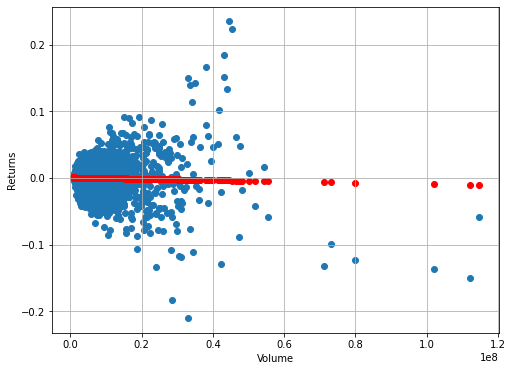

In [30]:
# Weighted regression

X1 = GSVol.values
X1 = sm.add_constant(X1) # Need to add a constant to account for intercept
y = GSrtn
model = sm.WLS(y, X1, weights=1/(1+GSVol)**2)
lm_wls = model.fit()
print(lm_wls.summary())

# Plot results
model_fitted_y = lm_wls.fittedvalues
x = GSVol
y = GSrtn
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('Returns')
plt.xlabel('Volume')
plt.scatter(x,model_fitted_y, color = 'red')
plt.show()


Try and find a model for the variance directly 
===
- By using the models above, we can choose a fitted curve which best describes the Residual Squares at every point x. 
- This approximation can therefore be used as an optimal weight to minimise variance under WLS. As seen in Lectures, the optimal choise is $w_i = 1/\sigma_i^2$.

In [31]:
# Choosing the most promising model as per above.

print(lm_var7.summary());


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     77.76
Date:                Fri, 30 Oct 2020   Prob (F-statistic):          6.53e-236
Time:                        10:32:32   Log-Likelihood:                 15476.
No. Observations:                3216   AIC:                        -3.091e+04
Df Residuals:                    3197   BIC:                        -3.080e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      4.876      0.0

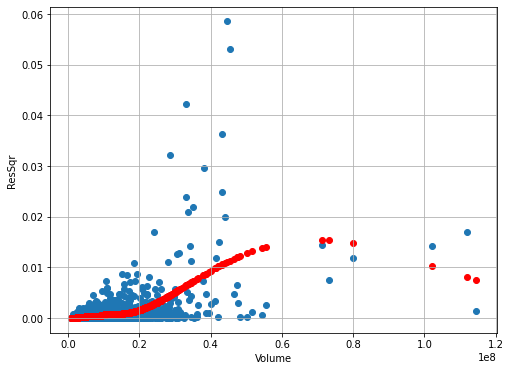

In [32]:
model_fitted_y = lm_var7.fittedvalues
plt.scatter(x=GSVol,y=resSqr)
plt.grid()
plt.ylabel('ResSqr')
plt.xlabel('Volume')
plt.scatter(x=GSVol,y=np.abs(model_fitted_y), color = 'red')
plt.show()


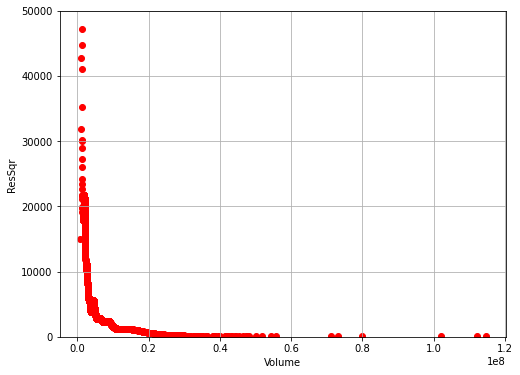

In [33]:
model_fitted_y = lm_var7.fittedvalues
plt.grid()
plt.ylabel('ResSqr')
plt.xlabel('Volume')
plt.scatter(x=GSVol,y=1/np.abs(model_fitted_y), color = 'red')
plt.ylim((0,5.0e4))
plt.show()

Seeking Homoscedasticity
===

In [34]:
# Taking the absolute value in case there are negative values
fittedweights=1/(abs(lm_var7.fittedvalues))

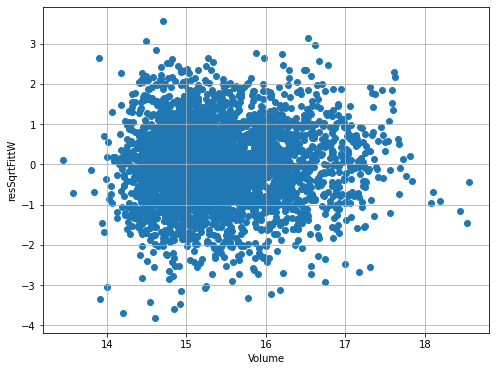

In [35]:
# Plotting in log scale x and visualising effect of scaling errors 
# with fitted model for variance.

x_log = np.log(GSVol)
y_temp = res*np.sqrt(fittedweights)

plt.scatter(x=x_log,y=y_temp)
plt.grid()
plt.ylabel('resSqrtFittW')
plt.xlabel('Volume')
plt.savefig("WhiteNoise2")

# The plot below seems homogeneous around the mean.

Using this knowledge to build the WLS
===

- Weighted regression of original model GSrtn as function of GSVol

In [36]:
# Weighted Linear Regression 

fittedweights=1/(abs(lm_var7.fittedvalues))

X1 = GSVol.values
X1 = sm.add_constant(X1) # Need to add a constant to account for intercept
y = GSrtn
model = sm.WLS(y, X1, weights=fittedweights)
lm_wls_2 = model.fit()
print(lm_wls_2.summary())

                            WLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.794
Date:                Fri, 30 Oct 2020   Prob (F-statistic):              0.181
Time:                        10:32:38   Log-Likelihood:                 8764.7
No. Observations:                3216   AIC:                        -1.753e+04
Df Residuals:                    3214   BIC:                        -1.751e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.821      0.0

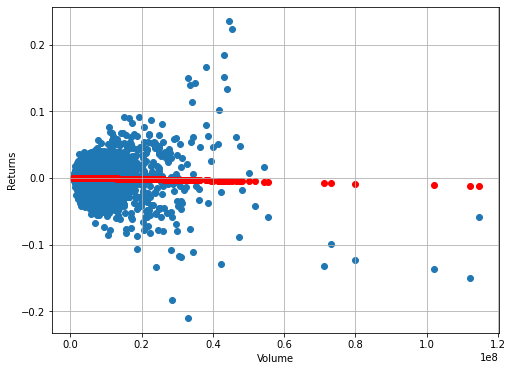

In [37]:
# Plot results
model_fitted_y = lm_wls_2.fittedvalues
x = GSVol
y = GSrtn
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('Returns')
plt.xlabel('Volume')
plt.scatter(x,model_fitted_y, color = 'red')
plt.show()

In [38]:
lm_wls_2.params

const    6.277060e-04
x1      -1.151702e-10
dtype: float64

In [39]:
lm_0.params

const    1.283851e-03
x1      -1.879812e-10
dtype: float64

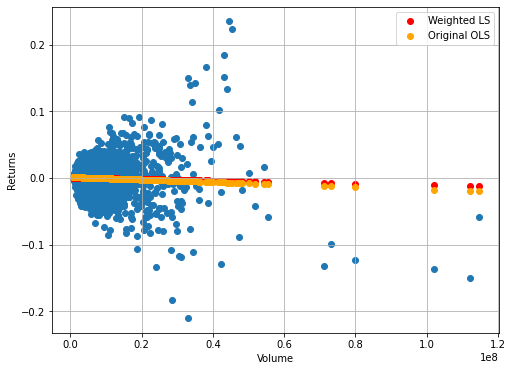

In [40]:
x = GSVol

y_fitted_model0 = lm_0.fittedvalues
model_fitted_y = lm_wls_2.fittedvalues
x = GSVol
y = GSrtn
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('Returns')
plt.xlabel('Volume')
plt.scatter(x,model_fitted_y, color = 'red', label = 'Weighted LS')
plt.scatter(x,y_fitted_model0, color = "orange",label = "Original OLS")
plt.legend()
plt.savefig("FinalWLS")



In [41]:
np.random.seed(17)

mu = 0
std = 1

a = 2
b = 0.5

# Create random variable from distribution used
rv = stats.norm(mu,std)
n = 200
    
def f(x,rv,n1,n2,n3):
    n = x.size
    y = np.zeros(n)
    y_data = np.zeros(n)
    z = rv.rvs(size = n)
    for i in range(n1):
        y_data[i] = a*x[i]+b + 50*z[i]
        y[i] = a*x[i]+b
    for i in range(n1,n2):
        y_data[i] = a*x[i]+b + 500*z[i]*z[i]
        y[i] = a*x[i]+b
    return y_data,y

In [42]:
x = np.linspace(1,100,100)
y_data,y = f(x,rv,50,100,1010)
type(y)

numpy.ndarray

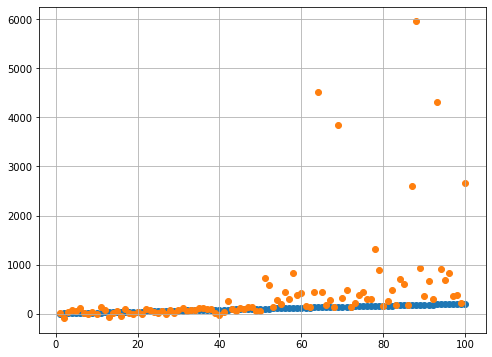

In [43]:
plt.scatter(x,y)
plt.scatter(x,y_data)
plt.grid()

In [44]:

X1 = x
X1 = sm.add_constant(X1) # Need to add a constant to account for intercept
y = y_data
model = sm.OLS(y, X1)
test = model.fit()
print(test.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.188
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     22.65
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           6.71e-06
Time:                        10:32:46   Log-Likelihood:                -819.12
No. Observations:                 100   AIC:                             1642.
Df Residuals:                      98   BIC:                             1647.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -277.5997    177.759     -1.562      0.1

Text(0, 0.5, '')

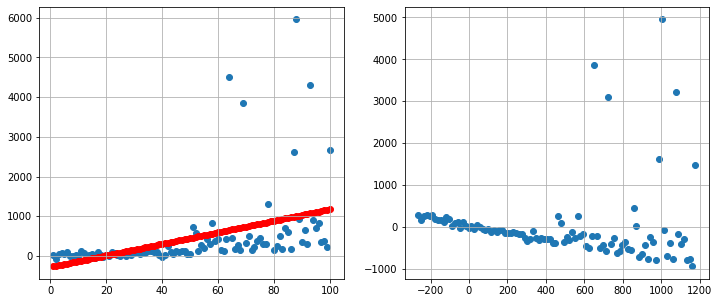

In [45]:
# Plot results
plt.figure(figsize=(12,5))
plt.subplot(1,2, 1)
model_fitted_y = test.fittedvalues
x = x
y = y_data
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('')
plt.xlabel('')
plt.scatter(x,model_fitted_y, color = 'red')
plt.subplot(1,2, 2)
x = model_fitted_y
y = test.resid
plt.scatter(x=x,y=y)
plt.grid()
plt.ylabel('')


In [46]:
res2 = test.resid**2
x = x
x2 = x**2
y = res2

X1 = np.stack((x,x2))
X1 = sm.add_constant(X1.T) # Need to add a constant to account for intercept


In [47]:
model = sm.OLS(y, X1)
var1 = model.fit()
print(var1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3.413
Date:                Fri, 30 Oct 2020   Prob (F-statistic):             0.0370
Time:                        10:32:47   Log-Likelihood:                -1634.4
No. Observations:                 100   AIC:                             3275.
Df Residuals:                      97   BIC:                             3283.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.659e+04    4.6e+05     -0.058      0.9

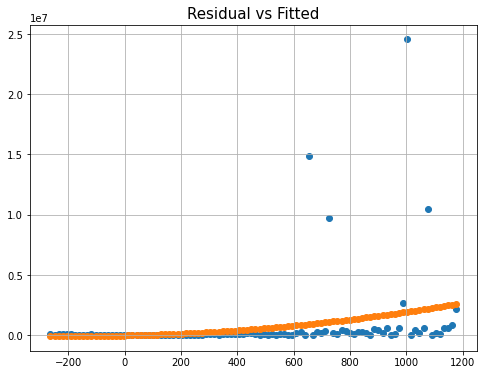

In [48]:
resVar1 = var1.resid
fitVar1 = var1.fittedvalues

plt.scatter(x,res2)
plt.scatter(x,fitVar1)
plt.title('Residual vs Fitted', fontsize = 15)
plt.grid()


In [49]:
# Taking the absolute value in case there are negative values
fittedweights=1/(abs(fitVar1))

X1 = x
X1 = sm.add_constant(x) # Need to add a constant to account for intercept
y = y_data
model = sm.WLS(y, X1, weights=fittedweights)
wls_1 = model.fit()
print(wls_1.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.197
Model:                            WLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     24.12
Date:                Fri, 30 Oct 2020   Prob (F-statistic):           3.63e-06
Time:                        10:32:48   Log-Likelihood:                -752.32
No. Observations:                 100   AIC:                             1509.
Df Residuals:                      98   BIC:                             1514.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.3796     22.761      2.038      0.0

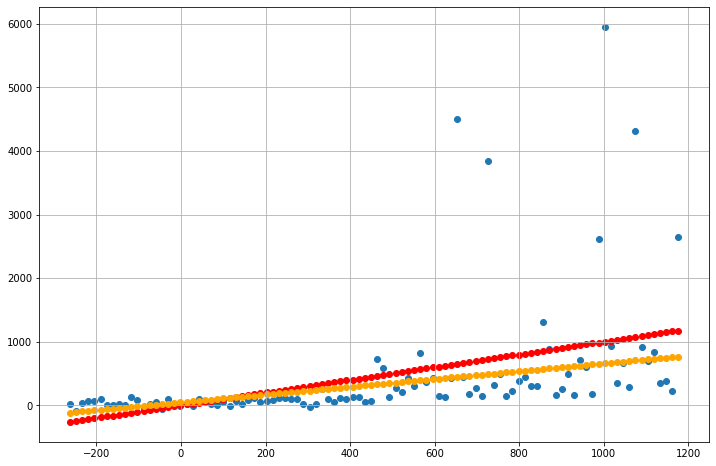

In [50]:
plt.figure(figsize=(12,8))

x = x
y = y_data
plt.scatter(x=x,y=y)
plt.scatter(x,model_fitted_y, color = 'red')
plt.scatter(x,wls_1.fittedvalues, color = 'orange')
plt.grid()




In [51]:
wls_1.params

array([46.37957299,  0.61293704])

In [52]:
test.params

array([-277.59966985,   14.54317041])